In [96]:
import time
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from abc import ABC, abstractmethod

from cryptography.hazmat.primitives.asymmetric import rsa, ec
from cryptography.hazmat.primitives import serialization, hashes
from cryptography.hazmat.primitives.ciphers.aead import ChaCha20Poly1305, AESGCM
from cryptography.hazmat.primitives.kdf.hkdf import HKDF

In [97]:
# Defined Scenarios with realistic file sizes
TEST_SCENARIOS = {
    "Tiny (Handshake/Auth)": 64,             # 64 Bytes
    "Small (Chat Message)": 512,             # 512 Bytes
    "Medium (JSON/API)": 4 * 1024,           # 4 KB
    "Large (Image/Doc)": 1024 * 1024,        # 1 MB
    "X-Large (App/Video)": 10 * 1024 * 1024, # 10 MB
    "Huge (Backup/ISO)": 50 * 1024 * 1024    # 50 MB (Change to 100MB if CPU is fast)
}

# We use fewer iterations for large files to save time, more for small files for accuracy
def get_iterations(size_bytes):
    if size_bytes > 10 * 1024 * 1024: return 5  # Large files: 5 runs
    if size_bytes > 1024 * 1024: return 20      # Medium files: 20 runs
    return 100                                  # Small files: 100 runs


In [98]:
class AsymmetricSystem(ABC):
    @abstractmethod
    def generate_keys(self): pass
    @abstractmethod
    def get_name(self): pass

# RSA
class RSA_Engine(AsymmetricSystem):
    def __init__(self, bits):
        self.bits = bits
    def get_name(self): return f"RSA-{self.bits}"
    
    def generate_keys(self):
        # RSA generation is very heavy [cite: 33]
        k = rsa.generate_private_key(public_exponent=65537, key_size=self.bits)
        return k.public_key()

# ECC
class ECC_NIST_Engine(AsymmetricSystem):
    def __init__(self, curve, name):
        self.curve = curve
        self.name = name
    def get_name(self): return f"ECC-{self.name}"
    
    def generate_keys(self):
        # ECC scalar multiplication is fast [cite: 47]
        k = ec.generate_private_key(self.curve)
        return k.public_key()

#  ECC (X25519)
class ECC_X25519_Engine(AsymmetricSystem):
    def get_name(self): return "ECC-X25519"
    
    def generate_keys(self):
        k = x25519.X25519PrivateKey.generate()
        return k.public_key()

In [99]:
class SymmetricSystem(ABC):
    @abstractmethod
    def encrypt(self, data: bytes, key: bytes) -> bytes: pass
    @abstractmethod
    def get_name(self): pass

class AES_GCM_Engine(SymmetricSystem):
    def get_name(self): return "AES-256-GCM"
    def encrypt(self, data, key):
        nonce = os.urandom(12)
        return AESGCM(key).encrypt(nonce, data, None)

class ChaCha20_Engine(SymmetricSystem):
    def get_name(self): return "ChaCha20-Poly1305"
    def encrypt(self, data, key):
        nonce = os.urandom(12)
        return ChaCha20Poly1305(key).encrypt(nonce, data, None)

In [100]:
class BenchmarkSuite:
    def __init__(self):
        self.results = []

    def measure(self, category, algo_name, task, func, size_bytes=0, size_label="-"):
        iters = get_iterations(size_bytes) if size_bytes > 0 else 20
        timings = []

        try:
            func() # Warm-up run
            for _ in range(iters):
                start = time.perf_counter()
                func()
                end = time.perf_counter()
                timings.append(end - start)
            
            avg_time = sum(timings) / len(timings)
            
            # Metrics
            throughput_mbps = 0
            if size_bytes > 0:
                throughput_mbps = (size_bytes / 1024 / 1024) / avg_time

            self.results.append({
                "Category": category,
                "Algorithm": algo_name,
                "Task": task,
                "Label": size_label,
                "Size_Bytes": size_bytes,
                "Time_Seconds": avg_time,
                "Throughput_MBps": throughput_mbps
            })
            print(f"   Done: {algo_name} ({size_label}) -> {avg_time:.5f}s")
            
        except Exception as e:
            print(f"   ERROR {algo_name}: {e}")

    def run_all(self):
        print("STARTING COMPREHENSIVE BENCHMARK...\n")
        
        # ASYMMETRIC TESTS
        print("--- Phase 1: Asymmetric Key Generation ---")
        algos = [
            RSA_Engine(2048), RSA_Engine(3072), RSA_Engine(4096),
            ECC_NIST_Engine(ec.SECP256R1(), "SECP256"),
            ECC_NIST_Engine(ec.SECP384R1(), "SECP384"),
            ECC_NIST_Engine(ec.SECP521R1(), "SECP521")
        ]
        for algo in algos:
            self.measure("Asymmetric", algo.get_name(), "KeyGen", algo.generate_keys)

        # SYMMETRIC TESTS 
        print("\n--- Phase 2: Symmetric Throughput ---")
        aes = AES_GCM_Engine()
        chacha = ChaCha20_Engine()
        key = os.urandom(32)

        for label, size in TEST_SCENARIOS.items():
            print(f"Testing Payload: {label}...")
            data = os.urandom(size)
            
            self.measure("Symmetric", aes.get_name(), "Encrypt", 
                         lambda: aes.encrypt(data, key), size, label)
            
            self.measure("Symmetric", chacha.get_name(), "Encrypt", 
                         lambda: chacha.encrypt(data, key), size, label)


    def get_results(self):
        return pd.DataFrame(self.results)

suite = BenchmarkSuite()
suite.run_all()
df = suite.get_results()

STARTING COMPREHENSIVE BENCHMARK...

--- Phase 1: Asymmetric Key Generation ---
   Done: RSA-2048 (-) -> 0.04334s
   Done: RSA-3072 (-) -> 0.18355s
   Done: RSA-4096 (-) -> 0.49498s
   Done: ECC-SECP256 (-) -> 0.00003s
   Done: ECC-SECP384 (-) -> 0.00125s
   Done: ECC-SECP521 (-) -> 0.00245s

--- Phase 2: Symmetric Throughput ---
Testing Payload: Tiny (Handshake/Auth)...
   Done: AES-256-GCM (Tiny (Handshake/Auth)) -> 0.00000s
   Done: ChaCha20-Poly1305 (Tiny (Handshake/Auth)) -> 0.00000s
Testing Payload: Small (Chat Message)...
   Done: AES-256-GCM (Small (Chat Message)) -> 0.00000s
   Done: ChaCha20-Poly1305 (Small (Chat Message)) -> 0.00000s
Testing Payload: Medium (JSON/API)...
   Done: AES-256-GCM (Medium (JSON/API)) -> 0.00000s
   Done: ChaCha20-Poly1305 (Medium (JSON/API)) -> 0.00001s
Testing Payload: Large (Image/Doc)...
   Done: AES-256-GCM (Large (Image/Doc)) -> 0.00061s
   Done: ChaCha20-Poly1305 (Large (Image/Doc)) -> 0.00084s
Testing Payload: X-Large (App/Video)...
   Done

In [101]:
sns.set_theme(style="whitegrid")

# --- HELPER: Format Bytes to Readable String ---
def format_size(size_bytes):
    if size_bytes == 0: return ""
    for unit in ['B', 'KB', 'MB', 'GB']:
        if size_bytes < 1024.0:
            return f"{size_bytes:3.0f} {unit}"
        size_bytes /= 1024.0
    return f"{size_bytes:.1f} GB"

df['Plot_Label'] = df.apply(
    lambda row: f"{row['Label']}\n[{format_size(row['Size_Bytes'])}]" if row['Size_Bytes'] > 0 else row['Label'], 
    axis=1
)

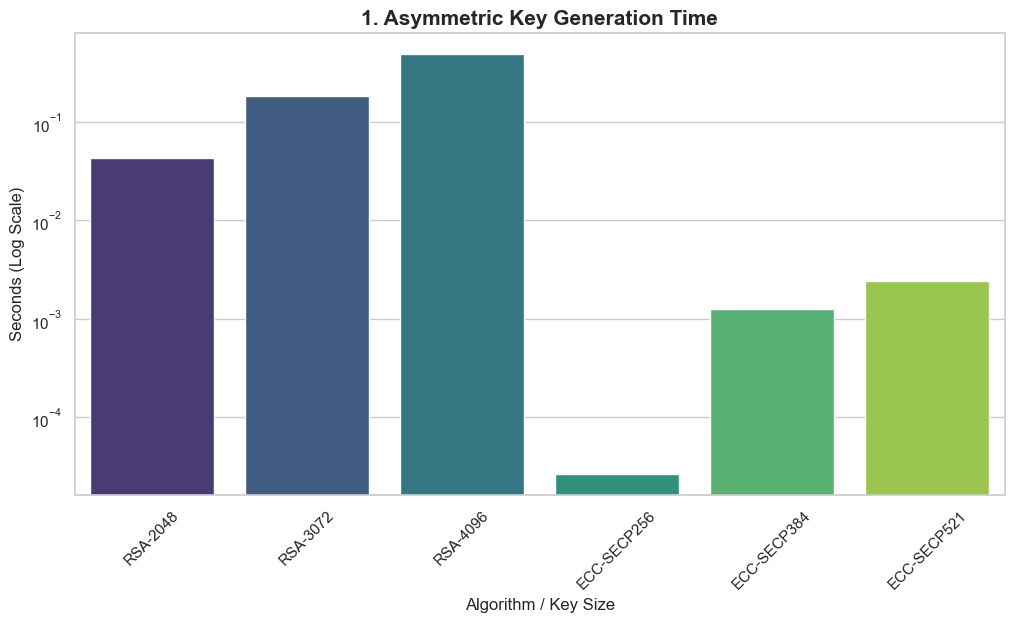

In [102]:
# Asymmetric Key Generation (Log Scale) 
plt.figure(figsize=(12, 6))
asym_df = df[df['Category'] == "Asymmetric"]

chart1 = sns.barplot(
    data=asym_df, 
    x="Algorithm", 
    y="Time_Seconds", 
    hue="Algorithm", 
    legend=False, 
    palette="viridis"
)
chart1.set_yscale("log") 
plt.title("1. Asymmetric Key Generation Time", fontweight='bold', fontsize=15)
plt.ylabel("Seconds (Log Scale)", fontsize=12)
plt.xlabel("Algorithm / Key Size", fontsize=12)
plt.xticks(rotation=45)
plt.show()

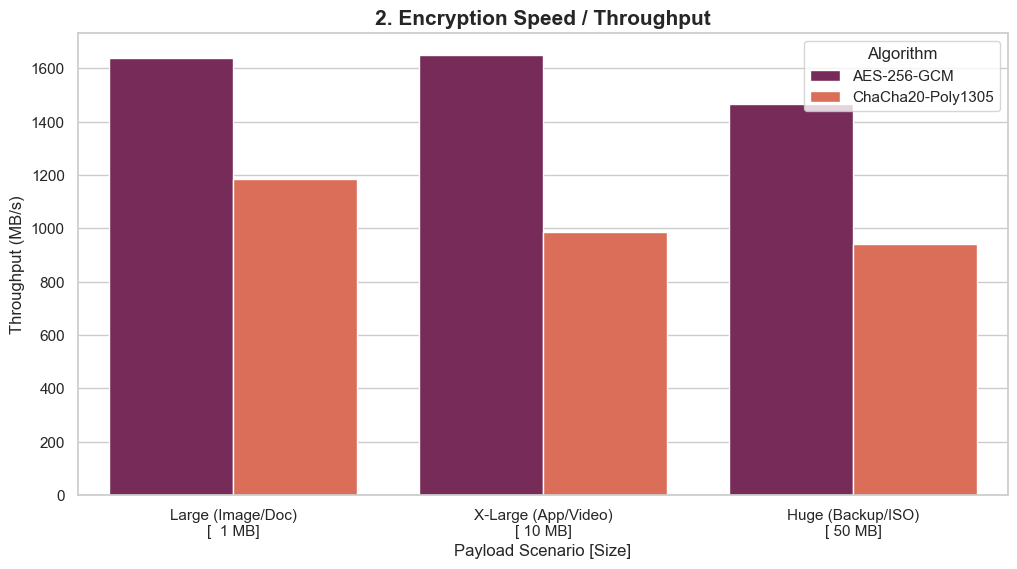

In [103]:
# Symmetric Throughput (MB/s) for Large Files 
plt.figure(figsize=(12, 6))
sym_df = df[(df['Category'] == "Symmetric") & (df['Size_Bytes'] >= 1024*1024)]

chart2 = sns.barplot(
    data=sym_df, 
    x="Plot_Label", 
    y="Throughput_MBps", 
    hue="Algorithm", 
    palette="rocket"
)
plt.title("2. Encryption Speed / Throughput", fontweight='bold', fontsize=15)
plt.ylabel("Throughput (MB/s)", fontsize=12)
plt.xlabel("Payload Scenario [Size]", fontsize=12)
plt.legend(title="Algorithm", loc='upper right')
plt.show()

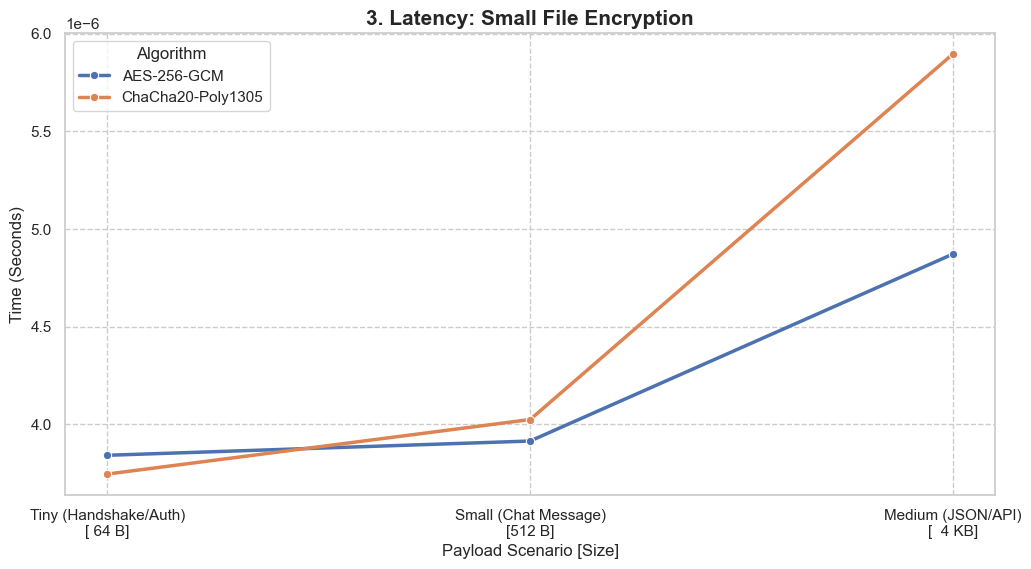

In [104]:
#  Latency for Small Files (Line Chart)
plt.figure(figsize=(12, 6))
# Filter for small files < 1MB
small_files_df = df[(df['Category'] == "Symmetric") & (df['Size_Bytes'] < 1024*1024)]

chart3 = sns.lineplot(
    data=small_files_df, 
    x="Plot_Label", 
    y="Time_Seconds", 
    hue="Algorithm", 
    marker="o", 
    linewidth=2.5
)
plt.title("3. Latency: Small File Encryption", fontweight='bold', fontsize=15)
plt.ylabel("Time (Seconds)", fontsize=12)
plt.xlabel("Payload Scenario [Size]", fontsize=12)
plt.grid(True, which="both", ls="--")
plt.show()

In [105]:
# --- DATA SUMMARY TABLE ---
display(df.groupby(['Category', 'Algorithm', 'Plot_Label'])[['Time_Seconds', 'Throughput_MBps']].mean())

Time_Seconds  \
Category   Algorithm         Plot_Label                                     
Asymmetric ECC-SECP256       -                                   0.000027   
           ECC-SECP384       -                                   0.001254   
           ECC-SECP521       -                                   0.002447   
           RSA-2048          -                                   0.043344   
           RSA-3072          -                                   0.183548   
           RSA-4096          -                                   0.494983   
Symmetric  AES-256-GCM       Huge (Backup/ISO)\n[ 50 MB]         0.034126   
                             Large (Image/Doc)\n[  1 MB]         0.000610   
                             Medium (JSON/API)\n[  4 KB]         0.000005   
                             Small (Chat Message)\n[512 B]       0.000004   
                             Tiny (Handshake/Auth)\n[ 64 B]      0.000004   
                             X-Large (App/Video)\n[ 10 MB]       0.006060   
           ChaCha20-Poly1305 Huge (Backup/ISO)\n[ 50 MB]         0.053014   
                             Large (Image/Doc)\n[  1 MB]         0.000844   
                             Medium (JSON/API)\n[  4 KB]         0.000006   
                             Small (Chat Message)\n[512 B]       0.000004   
                             Tiny (Handshake/Auth)\n[ 64 B]      0.000004   
                             X-Large (App/Video)\n[ 10 MB]       0.010126   

                                                             Throughput_MBps  
Category   Algorithm         Plot_Label                                       
Asymmetric ECC-SECP256       -                                      0.000000  
           ECC-SECP384       -                                      0.000000  
           ECC-SECP521       -                                      0.000000  
           RSA-2048          -                                      0.000000  
           RSA-3072          -                                      0.000000  
           RSA-4096          -                                      0.000000  
Symmetric  AES-256-GCM       Huge (Backup/ISO)\n[ 50 MB]         1465.171411  
                             Large (Image/Doc)\n[  1 MB]         1639.424928  
                             Medium (JSON/API)\n[  4 KB]          801.938355  
                             Small (Chat Message)\n[512 B]        124.752432  
                             Tiny (Handshake/Auth)\n[ 64 B]        15.890414  
                             X-Large (App/Video)\n[ 10 MB]       1650.212674  
           ChaCha20-Poly1305 Huge (Backup/ISO)\n[ 50 MB]          943.146025  
                             Large (Image/Doc)\n[  1 MB]         1185.461955  
                             Medium (JSON/API)\n[  4 KB]          662.638410  
                             Small (Chat Message)\n[512 B]        121.341756  
                             Tiny (Handshake/Auth)\n[ 64 B]        16.297825  
                             X-Large (App/Video)\n[ 10 MB]        987.549471